Bone Segmentation

In [147]:
import cv2
import nibabel as nib
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from skimage.filters import gaussian
from skimage.morphology import skeletonize, opening, binary_opening, disk
from scipy.ndimage import zoom, binary_fill_holes, distance_transform_edt
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max


In [61]:
ct_volume = nib.load("../results/3702_left_knee.nii.gz")
ct_data = ct_volume.get_fdata()
ct_data = ct_data.transpose((2, 1, 0))
spacing = ct_volume.header.get_zooms()

In [29]:
def show_mask(mask):
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.show()

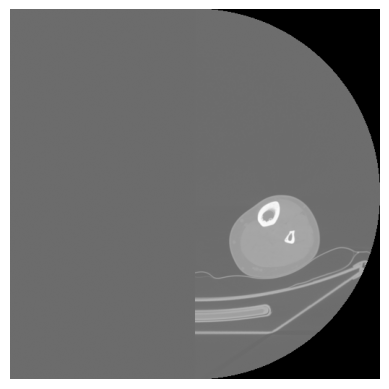

In [30]:
show_mask(ct_data[0])

In [66]:
binary_mask = np.zeros_like(ct_data)

In [259]:
def mask_slice(i):
    slice = ct_data[i]
    zoom_in = zoom(slice, (4,4), order=0)
    blur = gaussian(zoom_in, sigma=2)
    _, thresh = cv2.threshold(blur, 240, 255, cv2.THRESH_BINARY)
    zoom_out = zoom(thresh, (0.25, 0.25), order=0)
    return zoom_out

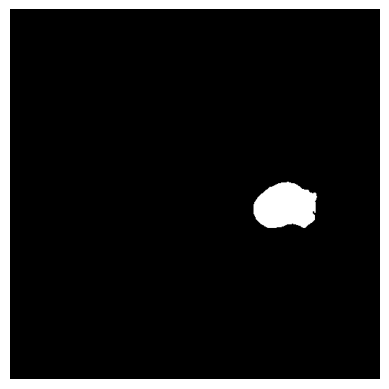

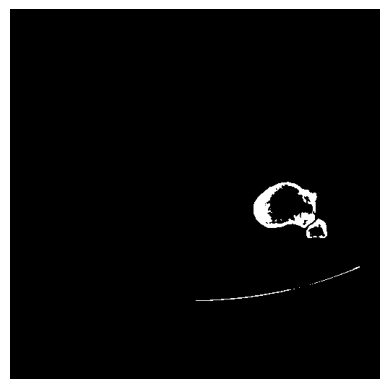

In [ ]:
for i in range(89, 90):
    mask = mask_slice(i)
    filled_mask = binary_fill_holes(mask)   
    opening = binary_opening(filled_mask, disk(1), mode="ignore")   # Morphological opening for removing lines and noises outside the region of interest
    clean_mask = remove_small_objects(filled_mask, min_size=800)    # Try different min_size such as 50, 100, 800, 1200 according to the slices

    # Use Distance Transform for slices 90 - 93
    distance = distance_transform_edt(clean_mask, sampling=spacing[:2])
    coords = peak_local_max(distance, footprint=np.ones((10,10)), labels=clean_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=clean_mask)
    labels[labels == 2] = 0

    # binary_mask[i] = clean_mask



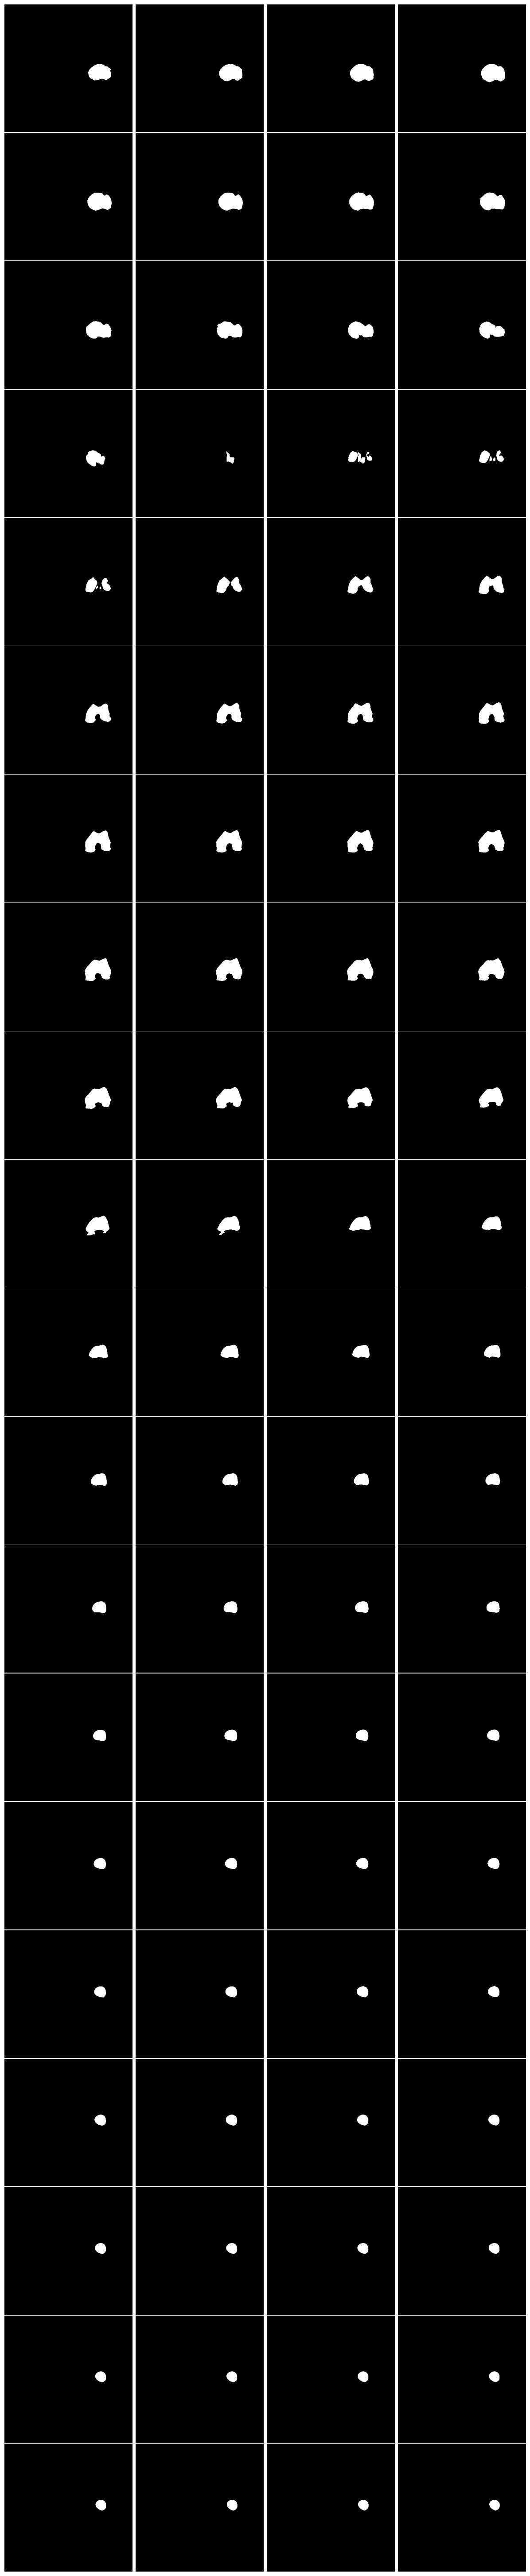

In [261]:
fig, axes = plt.subplots(20, 4, figsize=(12, 58))
for i, ax in enumerate(axes.flat):
    ax.imshow(binary_mask[i+90], cmap="gray")
    ax.axis("off")
plt.tight_layout(pad=0.1)
plt.show()

array([<Axes: >, <Axes: >], dtype=object)

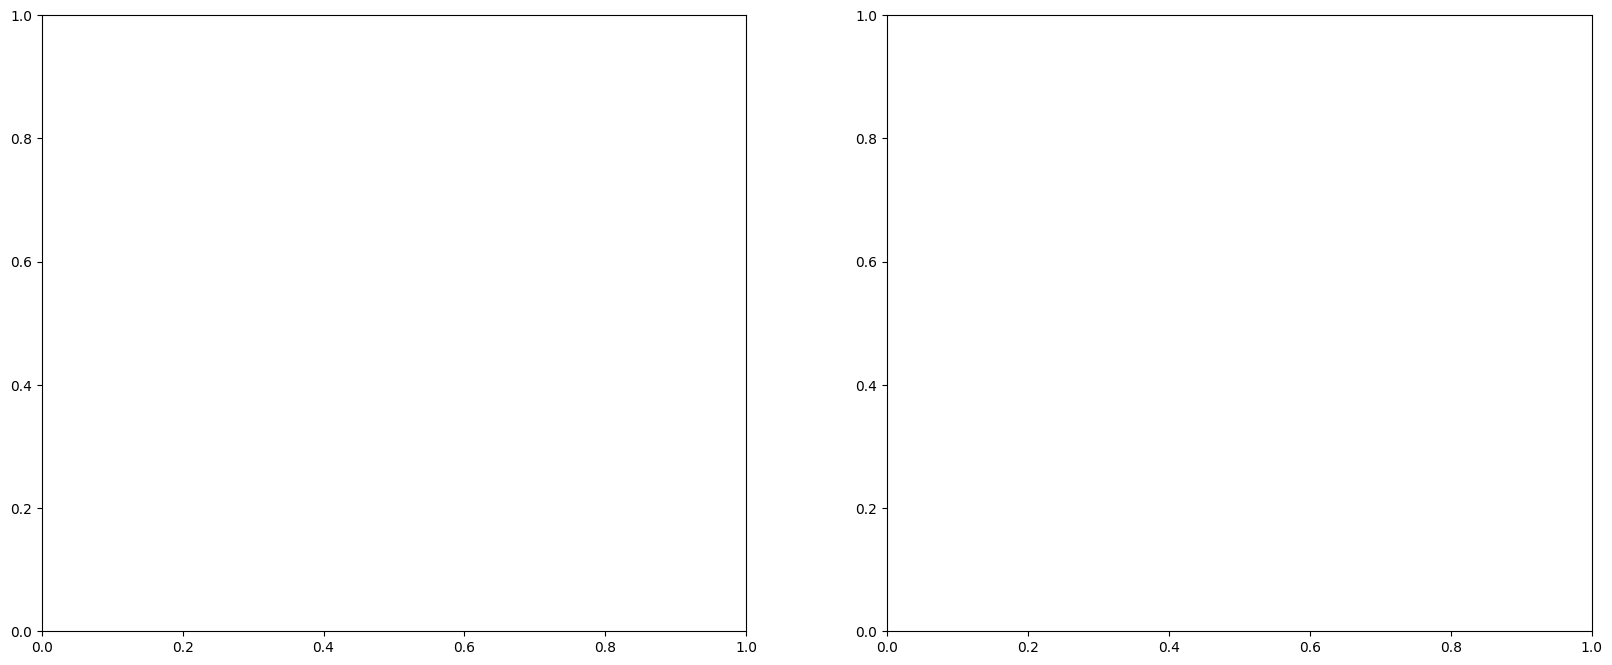

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
ax = axes.ravel()
ax[0].hist(ct_data[100])
ax[0].title("Slice 100")
ax[1].hist(zoom())

In [264]:
binary_mask.shape

(216, 512, 512)

In [271]:
nib.save(binary_mask, filename="../results/3702_left_knee_mask.nii.gz")

AttributeError: 'numpy.ndarray' object has no attribute 'to_filename'